<a href="https://colab.research.google.com/github/georgeto20/CIS-700-008/blob/hw2/action_castle_improved.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text adventure game

This Python notebook builds a simple text advenutre game inspired by the [Adventuron Classroom](https://adventuron.io/classroom/) design by Chris Ainsley of Adventuron Software Limited.

The main components are:
1. __The parser__, which interprets the player's commands.
2. __The game__, which represents the world (a collection of __locations__ and __items__), and describes what the player sees.
3. __The data__, which you input to create your own unique game.

## The Game Class
The game keeps track of the state of the world, and describes what the player sees as they move through different locations.

In [0]:
class Game:
  """The Game class represents the world.  Internally, we use a 
     graph of Location objects and Item objects, which can be at a 
     Location or in the player's inventory.  Each locations has a set of
     exits which are the directions that a player can move to get to an
     adjacent location. The player can move from one location to another
     location by typing a command like "Go North".
  """

  def __init__(self, start_at):
    # start_at is the location in the game where the player starts
    self.curr_location = start_at
    self.curr_location.has_been_visited = True
    # inventory is the set of objects that the player has collected/
    self.inventory = {}
    # Print the special commands associated with items in the game (helpful 
    # for debugging and for novice players).
    self.print_commands = True

  def describe(self):
    """Describe the current game state by first describing the current 
       location, then listing any exits, and then describing any objects
       in the current location."""
    self.describe_current_location()
    self.describe_exits()
    self.describe_items()

  def describe_current_location(self):
    """Describe the current location by printing its description field."""
    print(self.curr_location.description)

  def describe_exits(self):
    """List the directions that the player can take to exit from the current
       location."""
    exits = []
    for exit in self.curr_location.connections.keys():
      exits.append(exit.capitalize())
    if len(exits) > 0:
      print("Exits: ", end = '')
      print(*exits, sep = ", ",)
  
  def describe_items(self):
    """Describe what objects are in the current location."""
    if len(self.curr_location.items) > 0:
      print("You see: ")
      for item_name in self.curr_location.items:
        item = self.curr_location.items[item_name]
        print(item.description)
        if self.print_commands:
          special_commands = item.get_commands()
          for cmd in special_commands:
            print('\t', cmd)

  def add_to_inventory(self, item):
    """Add an item to the player's inventory."""
    self.inventory[item.name] = item
  
  def is_in_inventory(self,item):
    return item.name in self.inventory

  def get_items_in_scope(self):
    """Returns a list of items in the current location and in the inventory"""
    items_in_scope = []
    for item_name in self.curr_location.items:
      items_in_scope.append(self.curr_location.items[item_name])
    for item_name in self.inventory:
      items_in_scope.append(self.inventory[item_name])
    return items_in_scope

## Locations

Locations Locations are the places in the game that a player can visit.  They contain connects to other locations and items that the player can interact with.

In [0]:
class Location:
  """Locations are the places in the game that a player can visit.
     Internally they are represented nodes in a graph.  Each location stores
     a description of the location, any items in the location, its connections
     to adjacent locations, and any blocks that prevent movement to an adjacent
     location.  The connections is a dictionary whose keys are directions and
     whose values are the location that is the result of traveling in that 
     direction.  The travel_descriptions also has directions as keys, and its 
     values are an optional short desciption of traveling to that location.
  """
  def __init__(self, name, description, end_game=False):
    # A short name for the location
    self.name = name
    # A description of the location
    self.description = description
    # True if entering this location should end the game
    self.end_game = end_game
    # Dictionary mapping from directions to other Location objects
    self.connections = {}
    # Dictionary mapping from directions to text description of the path there
    self.travel_descriptions = {}
    # Dictionary mapping from item name to Item objects present in this location
    self.items = {}
    # Dictionary mapping from direction to Block object in that direction
    self.blocks = {}
    # Flag that gets set to True once this location has been visited by player
    self.has_been_visited = False

  def add_connection(self, direction, connected_location, travel_description=""):
    """Add a connection from the current location to a connected location.
       Direction is a string that the player can use to get to the connected
       location.  If the direction is a cardinal direction, then we also 
       automatically make a connection in the reverse direction."""
    self.connections[direction] = connected_location
    self.travel_descriptions[direction] = travel_description
    if direction == 'north':
      connected_location.connections["south"] = self
      connected_location.travel_descriptions["south"] = ""
    if direction == 'south':
      connected_location.connections["north"] = self
      connected_location.travel_descriptions["north"] = ""
    if direction == 'east':
      connected_location.connections["west"] = self
      connected_location.travel_descriptions["west"] = ""
    if direction == 'west':
      connected_location.connections["east"] = self
      connected_location.travel_descriptions["east"] = ""
    if direction == 'up':
      connected_location.connections["down"] = self
      connected_location.travel_descriptions["down"] = ""
    if direction == 'down':
      connected_location.connections["up"] = self
      connected_location.travel_descriptions["up"] = ""
    if direction == 'in':
      connected_location.connections["out"] = self
      connected_location.travel_descriptions["out"] = ""
    if direction == 'out':
      connected_location.connections["in"] = self
      connected_location.travel_descriptions["in"] = ""


  def add_item(self, name, item):
    """Put an item in this location."""
    self.items[name] = item

  def remove_item(self, item):
    """Remove an item from this location (for instance, if the player picks it
       up and puts it in their inventory)."""
    self.items.pop(item.name)


  def is_blocked(self, direction, game):
    """Check to if there is an obstacle in this direction."""
    if not direction in self.blocks:
        return False
    (block_description, preconditions) = self.blocks[direction]
    if check_preconditions(preconditions, game):
      # All the preconditions have been met.  You may pass.
      return False
    else: 
      # There are still obstalces to overcome or puzzles to solve.
      return True

  def get_block_description(self, direction):
    """Check to if there is an obstacle in this direction."""
    if not direction in self.blocks:
      return ""
    else:
      (block_description, preconditions) = self.blocks[direction]
      return block_description

  def add_block(self, blocked_direction, block_description, preconditions):
    """Create an obstacle that prevents a player from moving in the blocked 
       location until the preconditions are all met."""
    self.blocks[blocked_direction] = (block_description, preconditions)

## Checking Preconditions 
In text adventure games it's common to block a player's progress by creating blocks that prevent them from moving to a location.  For instance, a drawbridge might have a troll that you need to get rig of before you can cross into the castle, or a locked door might prevent you from entering a building until you have a key.  

This is a function that you can modify to include other preconditions.

In [0]:
def check_preconditions(preconditions, game, print_failure_reasons=True):
  """Checks whether the player has met all of the specified preconditions"""
  all_conditions_met = True
  for check in preconditions: 
    if check == "inventory_contains":
      item = preconditions[check]
      if not game.is_in_inventory(item):
        all_conditions_met = False
        if print_failure_reasons:
          print("You don't have the %s" % item.name)
    if check == "inventory_does_not_contain":
      item = preconditions[check]
      if game.is_in_inventory(item):
        all_conditions_met = False
    if check == "in_location":
      location = preconditions[check]
      if not game.curr_location == location:
        all_conditions_met = False
        if print_failure_reasons:
          print("You aren't in the correct location")
    if check == "location_has_item":
      item = preconditions[check]
      if not item.name in game.curr_location.items:
        all_conditions_met = False
        if print_failure_reasons:
          print("The %s isn't in this location" % item.name)
    if check == "location_does_not_have_item":
      item = preconditions[check]
      if item.name in game.curr_location.items:
        all_conditions_met = False
    # todo - add other types of preconditions
  return all_conditions_met

## Items
Items are objects that a player can get, or scenery that a player can examine. We could also implement people as items.  

In [0]:
class Item:
  """Items are objects that a player can get, or scenery that a player can
     examine."""
  def __init__(self,
               name,
               description,
               examine_text="",
               take_text="",
               start_at=None,
               gettable=True,
               end_game=False,
               linger_tol=0,
               kill_text=""):
    # The name of the object
    self.name = name
    # The default description of the object.
    self.description = description
    # The detailed description of the player examines the object.
    self.examine_text = examine_text
    # Text that displays when player takes an object.
    self.take_text = take_text if take_text else ("You take the %s." % self.name)
    # Indicates whether a player can get the object and put it in their inventory.
    self.gettable = gettable
    # True if entering this location should end the game.
    self.end_game = end_game
    # Number of moves player can make at location of character before character kills player (only relevant if >0).
    self.linger_tol = linger_tol
    # Linger tolerance at any given time.
    self.curr_linger_tol = linger_tol
    # Text that displays when player lingers in one location for too long and the game ends.
    self.kill_text = kill_text
    # Similarity threshold for finding most similar special command to user input
    self.threshold = 0.5
    # The location in the Game where the object starts.
    if start_at:
      start_at.add_item(name, self)
    self.commands = {}


  def get_commands(self):
    """Returns a list of special commands associated with this object"""
    return self.commands.keys()

  def add_action(self, command_text, function, arguments, preconditions={}):
    """Add a special action associated with this item"""
    self.commands[command_text] = (function, arguments, preconditions)

  def do_action(self, command_text, game):
    """Perform a special action associated with this item"""
    end_game = False  # Switches to True if this action ends the game.
    if command_text in self.commands:
      function, arguments, preconditions = self.commands[command_text]
      if check_preconditions(preconditions, game):
        end_game = function(game, arguments)
    else:
      print("Cannot perform the action %s" % command_text)
    return end_game

In [0]:
!pip3 install pymagnitude
!wget http://magnitude.plasticity.ai/glove/heavy/glove.6B.300d.magnitude
#!wget http://magnitude.plasticity.ai/word2vec/heavy/GoogleNews-vectors-negative300.magnitude

from pymagnitude import *
vectors = Magnitude("glove.6B.300d.magnitude")
#vectors = Magnitude("GoogleNews-vectors-negative300.magnitude")

     |████████████████████████████████| 5.4MB 3.1MB/s 
  Created wheel for pymagnitude: filename=pymagnitude-0.1.120-cp36-cp36m-linux_x86_64.whl size=135918205 sha256=9054bb176436669cf3c20c13da21e943adcd8deb175164b315ca2e3408931bdc
  Stored in directory: /root/.cache/pip/wheels/a2/c7/98/cb48b9db35f8d1a7827b764dc36c5515179dc116448a47c8a1
Successfully built pymagnitude
--2020-01-30 16:02:21--  http://magnitude.plasticity.ai/glove/heavy/glove.6B.300d.magnitude
Resolving magnitude.plasticity.ai (magnitude.plasticity.ai)... 52.216.242.123
Connecting to magnitude.plasticity.ai (magnitude.plasticity.ai)|52.216.242.123|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1384890368 (1.3G) [binary/octet-stream]
Saving to: ‘glove.6B.300d.magnitude’

glove.6B.300d.magni 100%[===================>]   1.29G  69.4MB/s    in 19s     

2020-01-30 16:02:40 (69.0 MB/s) - ‘glove.6B.300d.magnitude’ saved [1384890368/1384890368]



## The Parser
The parser is the module that handles the natural language understanding in the game.  The players enter commands in text, and the parser interprets them and performs the actions that the player intends.  This is the module with the most potential for improvement using modern natural language processing.  The implementation that I have given below only uses simple keyword matching.

In [0]:
class Parser:
  """The Parser is the class that handles the player's input.  The player 
     writes commands, and the parser performs natural language understanding
     in order to interpret what the player intended, and how that intent
     is reflected in the simulated world. 
  """
  def __init__(self, game):
    # A list of all of the commands that the player has issued.
    self.command_history = []
    # A pointer to the game.
    self.game = game

  def get_player_intent(self,command):
    command = command.lower()
    if "," in command:
      # Let the player type in a comma separted sequence of commands
      return "sequence"
    elif self.get_direction(command):
      # Check for the direction intent
      return "direction"
    elif command.lower() == "look" or command.lower() == "l":
      # when the user issues a "look" command, re-describe what they see
      return "redescribe"
    elif "examine " in command or command.lower().startswith("x "):
      return "examine"
    elif  "take " in command or "get " in command:
      return "take"
    elif "drop " in command:
      return "drop"
    elif "inventory" in command or command.lower() == "i":
      return "inventory"
    else: 
      items_in_scope = self.game.get_items_in_scope()
      most_likely_item = items_in_scope[0]
      special_commands = list(most_likely_item.get_commands())
      most_likely_command, largest_similarity = "", 0
      if len(special_commands) > 0:
          most_likely_command, largest_similarity = self.find_most_similar_command(command, special_commands, vectors, most_likely_item.threshold)
      for i in range(1, len(items_in_scope)):
          special_commands = list(items_in_scope[i].get_commands())
          if len(special_commands) > 0:
              most_similar_command, similarity = self.find_most_similar_command(command, special_commands, vectors, items_in_scope[i].threshold)
              if similarity > largest_similarity:
                  most_likely_item = items_in_scope[i]
                  most_likely_command, largest_similarity = most_similar_command, similarity
      if largest_similarity > most_likely_item.threshold:
          return "special"

  def parse_command(self, command):
    # add this command to the history
    self.command_history.append(command)

    # By default, none of the intents end the game. The following are ways this
    # flag can be changed to True.
    # * Going to a certain place.
    # * Entering a certain special command
    # * Picking up a certain object.

    end_game = False

    # Intents are functions that can be executed
    intent = self.get_player_intent(command)
    # Location before the player might go in some other direction
    prev_location = self.game.curr_location
    if intent == "direction":
      end_game = self.go_in_direction(command)
      # If player changed locations, then reset current linger tolerance to its original value
      if prev_location != self.game.curr_location:
          for item_name in self.game.curr_location.items:
              item = self.game.curr_location.items[item_name]
              if item.curr_linger_tol < item.linger_tol:
                  item.curr_linger_tol = item.linger_tol
    elif intent == "redescribe":
      self.game.describe()
    elif intent == "examine":
      self.examine(command)
    elif intent == "take":
      end_game = self.take(command)
    elif intent == "drop":
      self.drop(command)
    elif intent == "inventory":
      self.check_inventory(command)
    elif intent == "special":
      end_game = self.run_special_command(command)
    elif intent == "sequence":
      end_game = self.execute_sequence(command)
    else:
      print("I'm not sure what you want to do.")
    # If player stayed in the same location or issued a different command, decrement current linger tolerance by 1
    if intent == "direction" and prev_location == self.game.curr_location or intent != "direction" and intent != "sequence":
        for item_name in self.game.curr_location.items:
            item = self.game.curr_location.items[item_name]
            if item.curr_linger_tol > 0:
                item.curr_linger_tol -= 1
                # Print warning message just before current linger tolerance reaches 0
                if item.curr_linger_tol == 1:
                    if not end_game:
                        print("You have one move remaining until the %s kills you." % item_name)
                # End the game if current linger tolerance reaches 0
                if item.curr_linger_tol == 0:
                    if not end_game:
                        print(item.kill_text)
                    end_game = True
    return end_game

  ### Intent Functions ###

  def go_in_direction(self, command):
    """ The user wants to in some direction """
    direction = self.get_direction(command)

    if direction:
      if direction in self.game.curr_location.connections:
        if self.game.curr_location.is_blocked(direction, self.game):
          # check to see whether that direction is blocked.
          print(self.game.curr_location.get_block_description(direction))
        else:
          # if it's not blocked, then move there 
          self.game.curr_location = self.game.curr_location.connections[direction]

          # If moving to this location ends the game, only describe the location
          # and not the available items or actions.
          if self.game.curr_location.end_game:
            self.game.describe_current_location()
          else:
            self.game.describe()
      else:
        print("You can't go %s from here." % direction.capitalize())
    return self.game.curr_location.end_game

  def check_inventory(self,command):
    """ The player wants to check their inventory"""
    if len(self.game.inventory) == 0:
      print("You don't have anything.")
    else:
      descriptions = []
      for item_name in self.game.inventory:
        item = self.game.inventory[item_name]
        descriptions.append(item.description)
      print("You have: ", end = '')
      print(*descriptions, sep = ", ",)
  

  def examine(self, command):
    """ The player wants to examine something """
    command = command.lower()
    matched_item = False
    # check whether any of the items at this location match the command
    for item_name in self.game.curr_location.items:
      if item_name in command:
        item = self.game.curr_location.items[item_name]
        if item.examine_text:
          print(item.examine_text)
          matched_item = True
        break
    # check whether any of the items in the inventory match the command
    for item_name in self.game.inventory:
      if item_name in command:
        item = self.game.inventory[item_name]
        if item.examine_text:
          print(item.examine_text)
          matched_item = True
    # fail
    if not matched_item:
      print("You don't see anything special.")


  def take(self, command):
    """ The player wants to put something in their inventory """
    command = command.lower()
    matched_item = False

    # This gets set to True if posession of this object ends the game.
    end_game = False

    # check whether any of the items at this location match the command
    for item_name in self.game.curr_location.items:
      if item_name in command:
        item = self.game.curr_location.items[item_name]
        if item.gettable:
          self.game.add_to_inventory(item)
          self.game.curr_location.remove_item(item)
          print(item.take_text)
          end_game = item.end_game
        else:
          print("You cannot take the %s." % item_name)
        matched_item = True
        break
    # check whether any of the items in the inventory match the command
    if not matched_item:
      for item_name in self.game.inventory:
        if item_name in command:
          print("You already have the %s." % item_name)
          matched_item = True
    # fail
    if not matched_item:
      print("You can't find it.")

    return end_game

  def drop(self, command):
    """ The player wants to remove something from their inventory """
    command = command.lower()
    matched_item = False
    # check whether any of the items in the inventory match the command
    if not matched_item:
      for item_name in self.game.inventory:
        if item_name in command:
          matched_item = True
          item = self.game.inventory[item_name]
          self.game.curr_location.add_item(item_name, item)
          self.game.inventory.pop(item_name)
          print("You drop the %s." % item_name)
          break
    # fail
    if not matched_item:
      print("You don't have that.")


  def run_special_command(self, command):
    """Run a special command associated with one of the items in this location
       or in the player's inventory"""
    items_in_scope = self.game.get_items_in_scope()
    most_likely_item = items_in_scope[0]
    special_commands = list(most_likely_item.get_commands())
    most_likely_command, largest_similarity = "", 0
    if len(special_commands) > 0:
        most_likely_command, largest_similarity = self.find_most_similar_command(command, special_commands, vectors, most_likely_item.threshold)
    for i in range(1, len(items_in_scope)):
        special_commands = list(items_in_scope[i].get_commands())
        if len(special_commands) > 0:
            most_similar_command, similarity = self.find_most_similar_command(command, special_commands, vectors, items_in_scope[i].threshold)
            if similarity > largest_similarity:
                most_likely_item = items_in_scope[i]
                most_likely_command, largest_similarity = most_similar_command, similarity
    if largest_similarity > most_likely_item.threshold:
        if not command.lower() in most_likely_item.get_commands():
            print("It seems you're trying to:", most_likely_command)
        return most_likely_item.do_action(most_likely_command, self.game)

  def construct_sentence_vector(self, command, vectors):
    sentence_vector = np.zeros(shape=(vectors.dim,))
    for word in command.split():
      word_vector = vectors.query(word)
      sentence_vector += word_vector
    sentence_vector /= len(command.split())
    return sentence_vector

  def find_most_similar_command(self, user_command, known_commands, vectors, threshold):
    constructed_user_command = self.construct_sentence_vector(user_command, vectors)
    most_similar_command = known_commands[0]
    constructed_known_command = self.construct_sentence_vector(known_commands[0], vectors)
    largest_similarity = vectors.similarity(constructed_user_command, constructed_known_command)
    for i in range(1, len(known_commands)):
        constructed_known_command = self.construct_sentence_vector(known_commands[i], vectors)
        current_similarity = vectors.similarity(constructed_user_command, constructed_known_command)
        if current_similarity > largest_similarity:
            most_similar_command = known_commands[i]
            largest_similarity = current_similarity
    if largest_similarity > threshold:
        return (most_similar_command, largest_similarity)
    else:
        return ("", 0)

  def execute_sequence(self, command):
    for cmd in command.split(","):
      cmd = cmd.strip()
      end_game = self.parse_command(cmd)
      if end_game:
          return True

  def get_direction(self, command):
    command = command.lower()
    if command == "n" or "north" in command:
      return "north" 
    if command == "s" or "south" in command:
      return "south"
    if command == "e" or "east" in command: 
      return "east"
    if command == "w" or "west" in command:
      return "west"
    if command == "up":
      return "up"
    if command == "down":
      return "down"
    if command.startswith("go out"):
      return "out"
    if command.startswith("go in"):
      return "in"
    for exit in self.game.curr_location.connections.keys():
      if command == exit.lower() or command == "go " + exit.lower():
        return exit
    return None

## Special functions
Many times we want to add special behavior to items in the game.  For instance, we might want to be able to _pick a rose_ from a _rosebush_, or the _eat_ a _fish_.  In this implementation we do this in a pretty generic way by allowing the game developer to call ```Item.add_action(cmd,function,argment,preconditions)``` where ```function``` is any Python function. Some example of functions are defined below.

These functions should return True if the game is ended by the action, False otherwise.

In [0]:
def add_item_to_inventory(game, *args):
  """ Add a newly created Item and add it to your inventory."""
  (item, action_description, already_done_description) = args[0]
  if(not game.is_in_inventory(item)):
    print(action_description)
    game.add_to_inventory(item)
  else:
    print(already_done_description)
  return False

def add_action_to_character(game, *args):
  """Add new action to a character in the game."""
  (character, (new_commands)) = args[0]
  for command in new_commands:
      (command_text, function, arguments) = command
      character.add_action(command_text, function, arguments)
      print("\t", command_text)
  return False

def attempt_actions(game, *args):
  """Attempt actions and describe outcome based on
     whether or not item is in inventory."""
  (items, (actions), already_done_description, failure_action_description) = args[0]
  if game.is_in_inventory(items[0]):
      for action in actions:
          (function, arguments) = action
          end_the_game = function(game, arguments)
          if end_the_game:
            return True
  elif game.is_in_inventory(items[len(items)-1]):
      print(already_done_description)
  else:
      print(failure_action_description)
  return False

def change_description(game, *args):
  """Change description of an item or location."""
  (item_or_location, new_description) = args[0]
  item_or_location.description = new_description
  return False

def describe_something(game, *args):
  """Describe some aspect of the Item"""
  (description) = args[0]
  print(description)
  return False

def create_item(game, *args):
  """Creates a new Item in the game."""
  (item, action_description) = args[0]
  game.curr_location.add_item(item.name, item)
  print(action_description)
  return False

def destroy_item(game, *args):
  """Removes an Item from the game by setting its location is set to None."""
  (item, action_description) = args[0]
  if game.is_in_inventory(item):
    game.inventory.pop(item.name)
    print(action_description)
  elif item.name in game.curr_location.items:
    game.curr_location.remove_item(item)
    print(action_description)
  return False

def perform_multiple_actions(game, *args):
  """Performs multuple actions at the same time."""
  (actions) = args[0]
  for action in actions:
      (function, arguments) = action
      end_the_game = function(game, arguments)
      if end_the_game:
        return True
  return False

def end_game(game, *args):
  """Ends the game."""
  (end_message) = args[0]
  print(end_message)
  return True

## Game Data

Here's where you can define the locations and items in your game.  To get you started, I defined a super-simple fishing game, which contains the first 3 locations of __Action Castle__ by Jared A. Sorensen, which is part of the awesome book [Parsley](http://www.memento-mori.com/parsely-products/parsely-pdf).  

You can play through the whole game with the following commands:
1. take pole
2. go out
3. south 
4. catch fish with pole
5. eat fish

In [0]:
def build_game():
  # Locations
  cottage = Location("Cottage", "You are standing in a small cottage.")
  fishing_pond = Location("Fishing Pond", "You are at the edge of a small fishing pond.")
  garden_path = Location("Garden Path", "You are standing on a lush garden path. There is a cottage here.")
  winding_path = Location("Winding Path", "You are walking along a winding path. There is a tall tree here.")
  drawbridge = Location("Drawbridge", "You are standing on one side of a drawbridge leading to ACTION CASTLE.")
  top_of_the_tall_tree = Location("Top of the Tall Tree", "You are at the top of the tall tree.")
  courtyard = Location("Courtyard", "You are in the courtyard of ACTION CASTLE.")
  tower_stairs = Location("Tower Stairs", "You are climbing the stairs to the tower.")
  tower = Location("Tower", "You are inside a tower. The princess is here.")
  dungeon_stairs = Location("Dungeon Stairs", "You are climbing the stairs down to the dungeon.")
  dungeon = Location("Dungeon", "You are in the dungeon.")
  great_feasting_hall = Location("Great Feasting Hall", "You stand inside the Great Feasting Hall.")
  throne_room = Location("Throne Room", "You are in the throne room of ACTION CASTLE.")

  # Connections
  cottage.add_connection("out", garden_path)
  garden_path.add_connection("south", fishing_pond)
  garden_path.add_connection("north", winding_path)
  winding_path.add_connection("up", top_of_the_tall_tree)
  winding_path.add_connection("east", drawbridge)
  drawbridge.add_connection("east", courtyard)
  courtyard.add_connection("up", tower_stairs)
  courtyard.add_connection("down", dungeon_stairs)
  courtyard.add_connection("east", great_feasting_hall)
  tower_stairs.add_connection("up", tower)
  dungeon_stairs.add_connection("down", dungeon)
  great_feasting_hall.add_connection("east", throne_room)

  # Items that you can pick up
  fishing_pole = Item("pole", "a fishing pole", "A simple fishing pole.", start_at=cottage)
  rosebush = Item("rosebush", "a rosebush", "The rosebush contains a single red rose. It is beautiful.", start_at=garden_path)
  rose = Item("rose", "a red rose", "It smells good.",  start_at=None)
  fish = Item("fish", "a dead fish", "It smells terrible.", start_at=None)
  branch = Item("branch", "a stout, dead branch", "The branch is stout and dead.", "You have caused the branch to snap off.", start_at=top_of_the_tall_tree)
  key = Item("key", "a key", "A simple key.", start_at=None)
  lamp = Item("lamp", "a lamp", "A simple lamp.", start_at=None)
  candle = Item("candle", "a strange candle", "The candle is covered in strange runes.", start_at=great_feasting_hall)
  crown = Item("crown", "a crown", "The crown is golden and thorny.", start_at=None)
  worn_crown = Item("worn crown", "the crown to be worn", "You are wearing the crown.", start_at=None)

  # Sceneary (not things that you can pick up)
  pond = Item("pond", "a small fishing pond", "There are fish in the pond.", start_at=fishing_pond, gettable=False)
  top_of_tree = Item("tree", "top of tree", "You are at the top of the tall tree.", start_at=top_of_the_tall_tree, gettable=False)
  troll = Item("troll", "a mean troll", "The troll is warty, green, and hungry.", start_at=drawbridge, gettable=False,
               linger_tol=3, kill_text="The troll attacks and kills you because you lingered here for too long. THE END.")
  guard = Item("guard", "a guard carrying a sword and a key", "He looks at you suspiciously.", start_at=courtyard, gettable=False)
  unconscious_guard = Item("unconscious guard", "an unconscious guard is slumped against the wall", "He has bits of branch on his uniform.", start_at=None, gettable=False)
  sword = Item("sword", "a short sword", "It glistens in the light of the courtyard.", start_at=None, gettable=False)
  locked_door = Item("door", "a locked door", "The door can only be opened with a key.", start_at=tower_stairs, gettable=False)
  princess = Item("princess", "the princess", "The princess is beautiful, sad, and lonely. She awaits her prince.", start_at=tower, gettable=False)
  dung_stairs = Item("dungeon stairs", "the dark dungeon stairs", "You are descending down the dungeon stairs", start_at=dungeon_stairs, gettable=False)
  ghost = Item("ghost", "a spooky ghost", "The ghost has bony, claw-like fingers and wears a crown.", start_at=dungeon, gettable=False,
               linger_tol=2, kill_text="The ghost reaches out to stop your heart and you die because you lingered here for too long. THE END.")
  throne = Item("throne", "an ornate golden throne", "The throne is spectacularly designed.", start_at=throne_room, gettable=False)

  # Add special functions to your items
  rosebush.add_action("pick rose", add_item_to_inventory, (rose, "You pick the lone rose from the rosebush.", "You already picked the rose."))
  rose.add_action("smell rose", describe_something, ("It smells sweet."))
  pond.add_action("catch fish", describe_something, ("You reach into the pond and try to catch a fish with your hands, but they are too fast."))
  pond.add_action("catch fish with pole", perform_multiple_actions,
                  ([(add_item_to_inventory, (fish, "You dip your hook into the pond and catch a fish.","You weren't able to catch another fish.")),
                  (destroy_item, (fishing_pole, "In the process, the fishing pole breaks, so you leave it at the edge of the pond."))
                  ]), preconditions={"inventory_contains": fishing_pole})
  fish.add_action("eat fish", describe_something, ("That's disgusting! It's raw! And definitely not sashimi-grade!"))
  top_of_tree.add_action("jump", end_game, ("You do not survive the jump and are now dead. THE END."))
  troll.add_action("hit troll with branch", end_game, ("In retaliation, the troll attacks and kills you. THE END."), preconditions={"inventory_contains": branch})
  troll.add_action("give fish to troll", perform_multiple_actions,
      ([(destroy_item, (fish, "You feed the fish to the troll.")),
      (destroy_item, (troll, "The troll runs away."))
      ]), preconditions={"inventory_contains": fish})
  guard.add_action("hit guard with branch", perform_multiple_actions, 
      ([(destroy_item, (branch,"You swing your branch against the guard. It shatters to pieces.")),
      (destroy_item, (guard,"The guard slumps over, unconscious.")),
      (create_item, (unconscious_guard,"The guard's unconscious body lies on the ground.")),
      (create_item, (key,"His key falls from his hand.")),
      (create_item, (sword,"His short sword falls from its pouch."))
      ]), preconditions={"inventory_contains":branch , "location_has_item": guard})
  locked_door.add_action("unlock door", perform_multiple_actions, 
      ([(destroy_item, (key,"You place your key in the lock.")),
      (destroy_item, (locked_door,"The door has unlocked. It opens to reveal the magnificent tower."))
      ]), preconditions={"inventory_contains":key , "location_has_item": locked_door})
  princess.add_action("talk to princess", describe_something, ("You must first give the rose to the princess before she can speak."))
  princess.add_action("give rose to princess", perform_multiple_actions, 
      ([(destroy_item, (rose,"You give the rose to the princess.")),
      (add_action_to_character, (princess, ([("talk to princess", describe_something,
                                ("You must specify a topic: ghost, crown, herself, or throne")),
                                ("talk to princess about ghost", describe_something,
                                ("She responds, \"My father haunts the dungeon as a restless spirit.\"")),
                                ("talk to princess about crown", describe_something,
                                ("She responds, \"Only the rightful heir to the throne may wear it!\"")),
                                ("talk to princess about herself", describe_something,
                                ("She responds, \"I cannot leave this tower until I am married!\"")),
                                ("talk to princess about throne", describe_something,
                                ("She responds, \"Only the king may sit on the throne\"")),
                                ("kiss princess", attempt_actions, ([worn_crown],
                                ([(describe_something, ("You and the princess share a passionate kiss."))]), "", "She slaps you and says, \"Not until we're wed!\"")),
                                ("propose to the princess", attempt_actions, ([crown, worn_crown],
                                ([(destroy_item, (crown, "The princess says, \"My father’s crown! You have put his soul at rest and may now succeed him!\"")),
                                (create_item, (worn_crown, "She holds the crown, waiting for you to wear it.")),
                                (change_description, (great_feasting_hall, "The feasting hall is now full of revelers celebrating the new ruler of ACTION CASTLE.")),
                                (change_description, (throne_room, "The throne room is now full of courtiers, guards, and other subjects.")),
                                (change_description, (unconscious_guard, "the guard, now awoken, bowing down to you")),
                                (change_description, (courtyard, "The guard has now awoken, and he drops to a knee and hails his new king."))
                                ]), "You're already married, dumbo!", "She tells you, \"You're not royalty!\""))])))
      ]), preconditions={"inventory_contains":rose})
  dung_stairs.add_action("light lamp", destroy_item, (lamp, "The lamp is now lit. You may pass."), preconditions={"inventory_contains": lamp})
  ghost.add_action("light candle", perform_multiple_actions,
                  ([(destroy_item, (ghost, "The candle is now lit. It gives off a strange, acrid-smelling smoke that causes the ghost to drop its crown and flee.")),
                  (create_item, (crown, "The crown lies on the ground."))]), preconditions={"inventory_contains": candle})
  candle.add_action("read runes", describe_something, ("The words on the candle translate to, \"The runes seem to be a spell of exorcism.\""))
  worn_crown.add_action("wear crown", add_item_to_inventory, (worn_crown, "The crown fits you perfectly.", "You are already wearing the crown."))
  throne.add_action("sit on throne", end_game, ("You sit on the ornate golden throne. The people cheer for the new ruler of... ACTION CASTLE!"), preconditions={"inventory_contains": worn_crown})

  # Add blocks to certain locations
  drawbridge.add_block("east", "The troll blocks your way.", preconditions={"location_does_not_have_item": troll})
  courtyard.add_block("east", "The guard blocks your way.", preconditions={"location_does_not_have_item": guard})
  tower_stairs.add_block("up", "The door to the tower is locked.", preconditions={"location_does_not_have_item": locked_door})
  dungeon_stairs.add_block("down", "It is too dark to see!", preconditions={"inventory_does_not_contain": lamp})

  game = Game(cottage)
  game.add_to_inventory(lamp)
  return game


# Play the game
This small snippet of code is what you need to run the game.  Behold! The magestic prompt! 

In [15]:
def game_loop():
  game = build_game()
  parser = Parser(game)
  game.describe()

  command = ""
  while not (command.lower() == "exit" or command.lower == "q"):
    command = input(">")
    end_game = parser.parse_command(command)
    if end_game:
      return

game_loop()
print('THE GAME HAS ENDED.')

You are standing in a small cottage.
Exits: Out
You see: 
a fishing pole
>out
You are standing on a lush garden path. There is a cottage here.
Exits: In, South, North
You see: 
a rosebush
	 pick rose
>eat rose
It seems you're trying to: pick rose
You pick the lone rose from the rosebush.
>s
You are at the edge of a small fishing pond.
Exits: North
You see: 
a small fishing pond
	 catch fish
	 catch fish with pole
>eat fish
It seems you're trying to: catch fish
You reach into the pond and try to catch a fish with your hands, but they are too fast.
>eat fish with pole
It seems you're trying to: catch fish with pole
You don't have the pole
>n
You are standing on a lush garden path. There is a cottage here.
Exits: In, South, North
You see: 
a rosebush
	 pick rose
>e
You can't go East from here.
>n
You are walking along a winding path. There is a tall tree here.
Exits: South, Up, East
>e
You are standing on one side of a drawbridge leading to ACTION CASTLE.
Exits: West, East
You see: 
a mea

# Visualize your game
The code below allows you to create a directed graph that shows the locations in your game and how they are connected.  You can also save a PDF of your graph to your Google Drive with the `save_to_drive` method.  The output file will be called `game-visualization.pdf`.

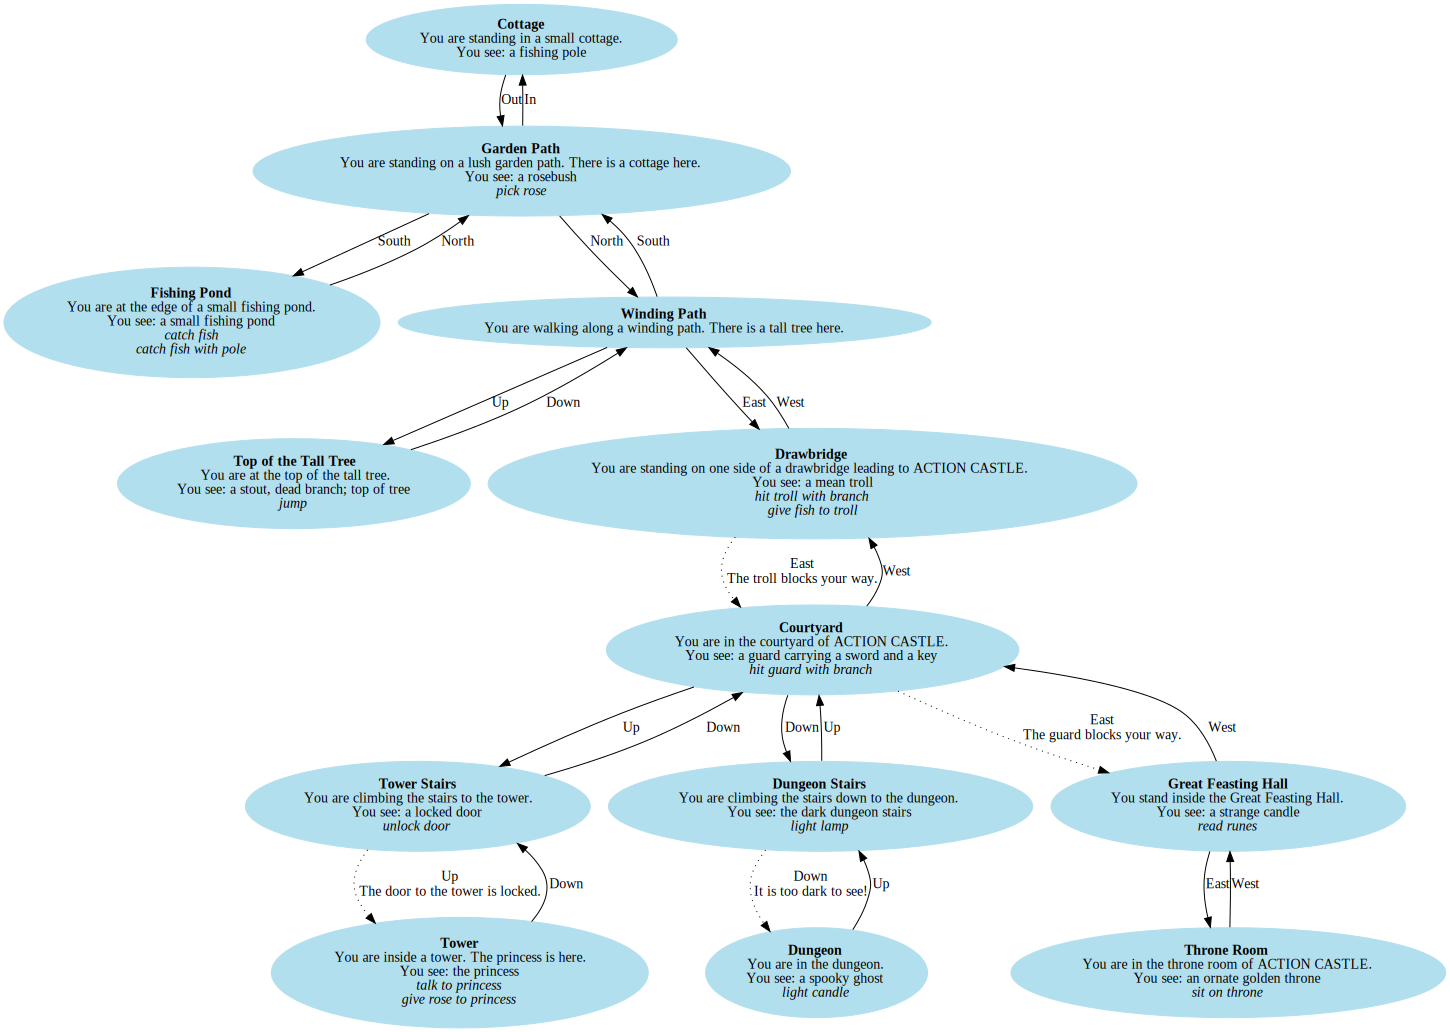

In [16]:
#!pip install graphviz
from graphviz import Digraph
from IPython.display import Image
import queue

def DFS(game, graph):
  """Do a depth-first-search traversal of the locations in the game
     starting at the start location, and create a GraphViz graph 
     to vizualize the connections between the locations, and the items
     that are located at each location."""
  start_location = game.curr_location
  frontier = queue.Queue()
  frontier.put(start_location)
  visited = {}
  visited[start_location.name] = True

  while not frontier.empty():
    current_location = frontier.get()
    game.curr_location = current_location
    name = current_location.name
    description = current_location.description
    items = current_location.items
    items_html = describe_items(current_location)
    html = "<<b>%s</b><br />%s<br />%s>" % (name, description, items_html)
    # Create a new node in the graph for this location
    graph.node(name, label=html)  

    connections = current_location.connections
    for direction in connections.keys():
      next_location = connections[direction]
      if not current_location.is_blocked(direction, game):
        # Create an edge between the current location and its successor
        graph.edge(name, next_location.name, label=direction.capitalize())
      else:
        # Create a dotted edge for connected locations that are blocked
        block_description = "%s\n%s" % (direction.capitalize(), current_location.get_block_description(direction))
        graph.edge(name, next_location.name, label=block_description, style="dotted")
      if not next_location.name in visited:
        visited[next_location.name] = True
        frontier.put(next_location)

def describe_items(location, print_commands=True):
    """Describe what objects are in the current location."""
    items_html = ""
    if len(location.items.keys()) > 0:
      items_html = "You see: "
    for i, item_name in enumerate(location.items):
      item = location.items[item_name]
      items_html += item.description
      if i < len(location.items) - 1:
        items_html += "; "
      if print_commands:
        special_commands = item.get_commands()
        for cmd in special_commands:
          items_html += "<br/><i>%s</i>" % cmd
    return items_html

def save_to_drive(graph):
  from google.colab import drive
  drive.mount('/content/drive/')
  graph.render('/content/drive/My Drive/game-visualization', view=True)  

graph = Digraph(node_attr={'color': 'lightblue2', 'style': 'filled'})
game = build_game()
DFS(game, graph)
#save_to_drive(graph)
graph
